In [22]:
import pandas as pd
import logging
import networkx as nx
import numpy as np

In [23]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Read MQ peptides reports

In [24]:
centers = {
    'Center1': '/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Center1/peptides.txt',
    'Center2': '/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Center2/peptides.txt',
    'Center3': '/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Center3/peptides.txt'
}
peptides_reports = {}

metadata = pd.read_csv('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Metadata_CosyBio.tsv', sep='\t')

for center in centers:
    data = pd.read_csv(centers[center], sep='\t')
    ####################### Filtering #######################
    # keep only rows with Reverse != '+'
    # data = data[data['Reverse'] != '+']
    # keep only rows with Potential contaminant != '+'
    # data = data[data['Potential contaminant'] != '+']
    # keep only columns with intensities + Majority protein IDs
    # create decoy column - True if Proteins is empty
    data['decoy'] = data['Proteins'].isnull()
    # if values in "Proteiins" column is NAN, replace it with "Leading razor protein
    data['Proteins'] = data['Proteins'].fillna(data['Leading razor protein'])
    data = data.filter(regex='(Sequence|^Proteins$|decoy|Score|Reporter intensity corrected)')

    print(f'Center: {center}')
    print(f'Number of features: {data.shape[0]}')
    ####################### Filter and replacement #######################
    # replace 0 with NaN in intensities_PG_from_pep
    # data = data.replace(0, pd.NA)
    # filter rows with less then 2 non NaN values
    # data = data.dropna(thresh=2)
    print(f'Number of features after filtering: {data.shape[0]}')

    peptides_reports[center] = data
    print('')

Center: Center1
Number of features: 5958
Number of features after filtering: 5958

Center: Center2
Number of features: 6303
Number of features after filtering: 6303

Center: Center3
Number of features: 5528
Number of features after filtering: 5528



In [25]:
peptides_reports['Center1'] = peptides_reports['Center1'].rename(columns={'Score': 'Score1'})
peptides_reports['Center2'] = peptides_reports['Center2'].rename(columns={'Score': 'Score2'})
peptides_reports['Center3'] = peptides_reports['Center3'].rename(columns={'Score': 'Score3'})

peptides_all = pd.merge(peptides_reports['Center1'], peptides_reports['Center2'], on=['Sequence', 'Proteins', 'decoy'], how='outer')
peptides_all = pd.merge(peptides_all, peptides_reports['Center3'], on=['Sequence', 'Proteins', 'decoy'], how='outer')

# fill NaN with 0
peptides_all = peptides_all.fillna(0)

peptides_all['score'] = peptides_all[['Score1', 'Score2', 'Score3']].max(axis=1, skipna=True)

peptides_all = peptides_all.loc[:,['Sequence', 'Proteins', 'score', 'decoy', *metadata['Quantitative column name'].tolist()]]


# rename Sequnce columns to sequence
peptides_all = peptides_all.rename(columns={'Sequence': 'sequence'})


print(f'Number of features in all centers (full join): {peptides_all.shape[0]}')
peptides_all.head()

Number of features in all centers (full join): 8824


,sequence,Proteins,score,decoy,Reporter intensity corrected 1 Pool1,Reporter intensity corrected 2 Pool1,Reporter intensity corrected 3 Pool1,Reporter intensity corrected 4 Pool1,Reporter intensity corrected 5 Pool1,Reporter intensity corrected 6 Pool1,...,Reporter intensity corrected 2 Pool6,Reporter intensity corrected 3 Pool6,Reporter intensity corrected 4 Pool6,Reporter intensity corrected 5 Pool6,Reporter intensity corrected 6 Pool6,Reporter intensity corrected 7 Pool6,Reporter intensity corrected 8 Pool6,Reporter intensity corrected 9 Pool6,Reporter intensity corrected 10 Pool6,Reporter intensity corrected 11 Pool6
0,AAAATGTIFTFR,P05154;G3V5I3,271.3500,False,9932.8,10121.0,10191.0,4770.3,8109.8,12217.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAAEVAGQFVIK,G3V0E5;A0A8V8TLM6;P02786;A0A8V8TM41;A0A8V8TLN0...,181.8700,False,10290.0,12784.0,10758.0,11639.0,28589.0,8405.1,...,47269.0,35796.0,42466.0,38417.0,31251.0,73083.0,39171.0,36858.0,35040.0,34171.0
2,AAAPNTPK,J3KP74;Q92954,133.1200,False,17777.0,9563.2,9668.6,7848.9,17987.0,10502.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AAASIVKVPVFKTETK,REV__A0A0A0MRA3,5.6597,True,9882.7,15669.0,9324.0,7593.7,6096.4,12475.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AAATGPSFWLGNETLK,A0A8V8TLL9;K7ES25;A0A494C165;P12955;A0A8V8TNF2...,180.9700,False,7181.6,17860.0,11005.0,17886.0,6825.8,12991.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Use alphapept grouping

From 

https://github.com/MannLabs/alphapept/blob/510c6e47dc04579233fcbc061746d59cd742be3a/alphapept/score.py#L635

In [26]:
def assign_proteins(data: pd.DataFrame, pept_dict: dict) -> (pd.DataFrame, dict):
    """
    Assign psms to proteins. 
    This function appends the dataframe with a column 'n_possible_proteins' which indicates how many proteins a psm could be matched to.
    It returns the appended dataframe and a dictionary `found_proteins` where each protein is mapped to the psms indices.
    
    Args:
        data (pd.DataFrame): psms table of scored and filtered search results from alphapept.
        pept_dict (dict): dictionary that matches peptide sequences to proteins

    Returns:
        pd.DataFrame: psms table of search results from alphapept appended with the number of matched proteins. 
        dict: dictionary mapping psms indices to proteins. 
    
    """
    
    data = data.reset_index(drop=True)
    
    data['n_possible_proteins'] = data['sequence'].apply(lambda x: len(pept_dict[x]))
    unique_peptides = (data['n_possible_proteins'] == 1).sum()
    shared_peptides = (data['n_possible_proteins'] > 1).sum()

    logging.info(f'A total of {unique_peptides:,} unique and {shared_peptides:,} shared peptides.')
    
    sub = data[data['n_possible_proteins']==1]
    psms_to_protein = sub['sequence'].apply(lambda x: pept_dict[x])

    found_proteins = {}
    for idx, _ in enumerate(psms_to_protein):
        idx_ = psms_to_protein.index[idx]
        p_str = 'p' + str(_[0])
        if p_str in found_proteins:
            found_proteins[p_str] = found_proteins[p_str] + [str(idx_)]
        else:
            found_proteins[p_str] = [str(idx_)] 
    
    return data, found_proteins

def get_shared_proteins(data: pd.DataFrame, found_proteins: dict, pept_dict: dict) -> dict:
    """
    Assign peptides to razor proteins. 
    
    Args:
        data (pd.DataFrame): psms table of scored and filtered search results from alphapept, appended with `n_possible_proteins`.
        found_proteins (dict): dictionary mapping psms indices to proteins
        pept_dict (dict): dictionary mapping peptide indices to the originating proteins as a list

    Returns:
        dict: dictionary mapping peptides to razor proteins
    
    """
    
    G = nx.Graph()

    sub = data[data['n_possible_proteins']>1]

    for i in range(len(sub)):
        seq, score = sub.iloc[i][['sequence','score']]
        idx = sub.index[i]
        possible_proteins = pept_dict[seq]

        for p in possible_proteins:
            G.add_edge(str(idx), 'p'+str(p), score=score)
            
    connected_groups = np.array([list(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)], dtype=object)
    n_groups = len(connected_groups)

    logging.info('A total of {} ambigious proteins'.format(len(connected_groups)))

    #Solving with razor:
    found_proteins_razor = {}
    for a in connected_groups[::-1]:
        H = G.subgraph(a).copy()
        shared_proteins = list(np.array(a)[np.array(list(i[0] == 'p' for i in a))])

        while len(shared_proteins) > 0:
            neighbors_list = []

            for node in shared_proteins:
                shared_peptides = list(H.neighbors(node))

                if node in G:
                    if node in found_proteins.keys():
                        shared_peptides += found_proteins[node]

                n_neigbhors = len(shared_peptides)

                neighbors_list.append((n_neigbhors, node, shared_peptides))


            #Check if we have a protein_group (e.g. they share the same everythin)
            neighbors_list.sort()

            # Check for protein group
            node_ = [neighbors_list[-1][1]]
            idx = 1
            while idx < len(neighbors_list): #Check for protein groups
                if neighbors_list[-idx][0] == neighbors_list[-idx-1][0]: #lenght check
                    if set(neighbors_list[-idx][2]) == set(neighbors_list[-idx-1][2]): #identical peptides
                        node_.append(neighbors_list[-idx-1][1])
                        idx += 1
                    else:
                        break   
                else:
                    break

            #Remove the last entry:  
            shared_peptides = neighbors_list[-1][2]
            for node in node_:
                shared_proteins.remove(node)

            for _ in shared_peptides:
                if _ in H:
                    H.remove_node(_)

            if len(shared_peptides) > 0:
                if len(node_) > 1:
                    node_ = tuple(node_)
                else:
                    node_ = node_[0]

                found_proteins_razor[node_] = shared_peptides
            
    return found_proteins_razor



def get_protein_groups(data: pd.DataFrame, pept_dict: dict, fasta_dict: dict, decoy = False, callback = None, **kwargs) -> pd.DataFrame:
    """
    Function to perform protein grouping by razor approach.
    This function calls `assign_proteins` and `get_shared_proteins`.
    ToDo: implement callback for solving
    Each protein is indicated with a p -> protein index
 
    Args:
        data (pd.DataFrame): psms table of scored and filtered search results from alphapept.
        pept_dict (dict): A dictionary mapping peptide indices to the originating proteins as a list.
        fasta_dict (dict): A dictionary with fasta sequences.
        decoy (bool, optional): Defaults to False.
        callback (bool, optional): Defaults to None.

    Returns:
        pd.DataFrame: alphapept results table now including protein level information.
    """
    data, found_proteins = assign_proteins(data, pept_dict)
    found_proteins_razor = get_shared_proteins(data, found_proteins, pept_dict)

    report = data.copy()
 
    assignment = np.zeros(len(report), dtype=object)
    assignment[:] = ''
    assignment_pg = assignment.copy()
    
    assignment_idx = assignment.copy()
    assignment_idx[:] = ''
    
    razor = assignment.copy()
    razor[:] = False
    
    # if decoy:
    #     add = 'REV__'
    # else:
    #     add = ''

    add = ''

    for protein_str in found_proteins.keys():
        protein = int(protein_str[1:])
        protein_name = add+fasta_dict[protein]['name']
        indexes = [int(_) for _ in found_proteins[protein_str]]
        assignment[indexes] = protein_name
        assignment_pg[indexes] = protein_name
        assignment_idx[indexes] = str(protein)

    for protein_str in found_proteins_razor.keys():
        indexes = [int(_) for _ in found_proteins_razor[protein_str]]  
        
        if isinstance(protein_str, tuple):
            proteins = [int(_[1:]) for _ in protein_str]
            protein_name = ';'.join([add+fasta_dict[_]['name'] for _ in proteins])
            protein = ';'.join([str(_) for _ in proteins])
        
        else:            
            protein = int(protein_str[1:])   
            protein_name = add+fasta_dict[protein]['name']
        
        assignment[indexes] = protein_name
        assignment_pg[indexes] = protein_name
        assignment_idx[indexes] = str(protein)
        razor[indexes] = True

    report['protein'] = assignment
    report['protein_group'] = assignment_pg
    report['razor'] = razor
    report['protein_idx'] = assignment_idx

    return report

def perform_protein_grouping(data: pd.DataFrame, pept_dict: dict, fasta_dict: dict, **kwargs) -> pd.DataFrame:
    """
    Wrapper function to perform protein grouping by razor approach
    
    Args:
        data (pd.DataFrame): psms table of scored and filtered search results from alphapept.
        pept_dict (dict): A dictionary mapping peptide indices to the originating proteins as a list.
        fasta_dict (dict): A dictionary with fasta sequences.

    Returns:
        pd.DataFrame: alphapept results table now including protein level information.
    """
    data_sub = data[['sequence','score','decoy']]
    data_sub_unique = data_sub.groupby(['sequence','decoy'], as_index=False).agg({"score": "max"})

    targets = data_sub_unique[data_sub_unique.decoy == False]
    targets = targets.reset_index(drop=True)
    protein_targets = get_protein_groups(targets, pept_dict, fasta_dict, **kwargs)
    
    protein_targets['decoy_protein'] = False

    decoys = data_sub_unique[data_sub_unique.decoy == True]
    decoys = decoys.reset_index(drop=True)
    protein_decoys = get_protein_groups(decoys, pept_dict, fasta_dict, decoy=True, **kwargs)

    protein_decoys['decoy_protein'] = True

    protein_groups = pd.concat([protein_targets, protein_decoys])
    protein_groups_app = protein_groups[['sequence','decoy','protein','protein_group','razor','protein_idx','decoy_protein','n_possible_proteins']]
    protein_report = pd.merge(data,
                                protein_groups_app,
                                how = 'inner',
                                on = ['sequence','decoy'],
                                validate="many_to_one")
    
    
    return protein_report

In [27]:
pept_dict = {}
protein_set = set()

for idx, row in peptides_all.iterrows():
    protein_set.update(row['Proteins'].split(';'))

print(f'Number of proteins: {len(protein_set)}')

# Create a dict with protein inxed as a key and protein name as a value in fasta_dict
fasta_dict = {}
protein_list = list(protein_set)

for idx, protein in enumerate(protein_list):
    fasta_dict[idx] = {'name': protein}

# take Sequence and Proteins columns from peptides_all and put Sequence as key and Proteins as value
for idx, row in peptides_all.iterrows():
    # use sequence as key and proteins as value, but use protien index
    pept_dict[row['sequence']] = [str(protein_list.index(protein)) for protein in row['Proteins'].split(';')]
    


Number of proteins: 3001


In [28]:
# keep only majority)

report = perform_protein_grouping(peptides_all, pept_dict, fasta_dict)

report = report.drop(
    columns=['sequence', 'Proteins', 'score', 'decoy', 'protein', 'n_possible_proteins', 
             'razor', 'protein_idx', 'decoy_protein']
    ).reset_index(drop=True)
report['protein_group'] = report['protein_group'].apply(
    lambda x: ';'.join(list(dict.fromkeys(sorted([element for element in x.split(';')]))))
)
report.head()

2024-04-22 18:25:42,299 - INFO - A total of 2,934 unique and 4,809 shared peptides.
2024-04-22 18:25:43,394 - INFO - A total of 407 ambigious proteins
2024-04-22 18:25:43,515 - INFO - A total of 50 unique and 0 shared peptides.
2024-04-22 18:25:43,516 - INFO - A total of 0 ambigious proteins


,Reporter intensity corrected 1 Pool1,Reporter intensity corrected 2 Pool1,Reporter intensity corrected 3 Pool1,Reporter intensity corrected 4 Pool1,Reporter intensity corrected 5 Pool1,Reporter intensity corrected 6 Pool1,Reporter intensity corrected 7 Pool1,Reporter intensity corrected 8 Pool1,Reporter intensity corrected 9 Pool1,Reporter intensity corrected 10 Pool1,...,Reporter intensity corrected 3 Pool6,Reporter intensity corrected 4 Pool6,Reporter intensity corrected 5 Pool6,Reporter intensity corrected 6 Pool6,Reporter intensity corrected 7 Pool6,Reporter intensity corrected 8 Pool6,Reporter intensity corrected 9 Pool6,Reporter intensity corrected 10 Pool6,Reporter intensity corrected 11 Pool6,protein_group
0,9932.8,10121.0,10191.0,4770.3,8109.8,12217.0,12637.0,7853.4,12351.0,10410.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P05154
1,10290.0,12784.0,10758.0,11639.0,28589.0,8405.1,9419.1,11465.0,12787.0,12657.0,...,35796.0,42466.0,38417.0,31251.0,73083.0,39171.0,36858.0,35040.0,34171.0,A0A8V8TLM6;G3V0E5;P02786
2,17777.0,9563.2,9668.6,7848.9,17987.0,10502.0,10021.0,8529.6,11911.0,8732.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Q92954
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25161.0,36709.0,48068.0,39687.0,23520.0,42810.0,42499.0,40598.0,35713.0,Q92954
4,9882.7,15669.0,9324.0,7593.7,6096.4,12475.0,9141.1,9929.8,14059.0,10934.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,REV__A0A0A0MRA3


In [29]:
def find_leading(features):
    # Filter the counts for the genes in the set
    relevant_counts = {feature: razor_uniq_dict[feature] for feature in features}
    # Find the max count
    max_count = max(relevant_counts.values())
    leading_genes = [feature for feature, count in relevant_counts.items() if count >= max_count / 2]
    
    return ';'.join(list(dict.fromkeys(sorted(leading_genes))))
# For making Majorite protein ID lists

peptides_proteins = peptides_all[['sequence', 'Proteins']].copy()
feature_column = 'Proteins'

df_exploded = peptides_proteins.assign(**{feature_column: peptides_proteins[feature_column].str.split(';')}
                                    ).explode(feature_column)
unique_razor = df_exploded[feature_column].value_counts().rename_axis(feature_column
                                                                      ).reset_index(name='Unique_razor')
razor_uniq_dict = pd.Series(unique_razor['Unique_razor'].values, index=unique_razor[feature_column]).to_dict()
unique_razor.head()




report['Major_PG'] = report['protein_group'].apply(lambda x: find_leading(x.split(';')))
report['protein_group'] = report['Major_PG']


In [30]:
alphapept_res = report.groupby('protein_group').agg({**{col: 'sum' for col in report.columns if 'intensity' in col}})
alphapept_res = alphapept_res.reset_index()

#rename to ProteinGroup
alphapept_res = alphapept_res.rename(columns={'protein_group': 'ProteinGroup'})
print(f'Number of features in alphapept report: {alphapept_res.shape[0]}')

alphapept_PG = alphapept_res['ProteinGroup'].tolist()

alphapept_res.head()



Number of features in alphapept report: 699


,ProteinGroup,Reporter intensity corrected 1 Pool1,Reporter intensity corrected 2 Pool1,Reporter intensity corrected 3 Pool1,Reporter intensity corrected 4 Pool1,Reporter intensity corrected 5 Pool1,Reporter intensity corrected 6 Pool1,Reporter intensity corrected 7 Pool1,Reporter intensity corrected 8 Pool1,Reporter intensity corrected 9 Pool1,...,Reporter intensity corrected 2 Pool6,Reporter intensity corrected 3 Pool6,Reporter intensity corrected 4 Pool6,Reporter intensity corrected 5 Pool6,Reporter intensity corrected 6 Pool6,Reporter intensity corrected 7 Pool6,Reporter intensity corrected 8 Pool6,Reporter intensity corrected 9 Pool6,Reporter intensity corrected 10 Pool6,Reporter intensity corrected 11 Pool6
0,A0A024R5G9;A0A7I2V2K3;A0A7I2V3M3;A0A7I2V3X1;A0...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A0A024R6N5,1472849.4,1120741.4,1128852.9,866950.7,1190039.6,934534.6,1217250.3,999954.6,1244069.0,...,111392308.0,17023683.0,38419619.0,20301309.0,26271353.0,19567586.0,30274664.0,210244670.0,18836251.0,18068842.0
2,A0A075B6H9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40876.0,50691.0,58515.0,32968.0,38083.0,37138.0,35395.0,51815.0,52347.0,35346.0
3,A0A075B6I0,5056.4,19022.3,10473.7,6561.4,6814.2,7565.9,6963.4,17171.8,6992.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A0A075B6I9;P04211,7923.6,22406.0,14546.0,18154.0,10296.0,14781.0,9538.2,24929.0,9952.7,...,83664.0,125190.0,65350.0,80610.0,75906.0,76086.0,87507.0,73270.0,109490.0,80759.0


# The same but using "custom grouping"

In [37]:
final_matching = pd.read_csv('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/04_Peptides_PG/Center1/mapping.tsv', sep='\t')
final_matching = final_matching.rename(columns={'peptides': 'sequence'})

aggregated_report = pd.merge(peptides_all, final_matching, on='sequence', how='left')
aggregated_report[['major_features']] = aggregated_report[['major_features']].astype(str)
aggregated_report = aggregated_report.drop(columns=['sequence', 'Proteins', 'decoy', 'score', 'features', 'razor_feature'])
aggregated_report['major_features'] = aggregated_report['major_features'].apply(
    lambda x: ';'.join(list(dict.fromkeys(sorted([element for element in x.split(';')])))))

custom_res = aggregated_report.groupby('major_features').agg({**{col: 'sum' for col in report.columns if 'intensity' in col}})
custom_res = custom_res.reset_index()

# change values in major_features
# split row value by ';', sort it and join by ';'
custom_res['major_features'] = custom_res['major_features'].apply(
    lambda x: ';'.join(sorted(x.split(';'))))
#rename to MajorFeatures
custom_res = custom_res.rename(columns={'major_features': 'ProteinGroup'})

print(f'Number of features in custom report: {custom_res.shape[0]}')

custom_PG = custom_res['ProteinGroup'].tolist()

custom_res.head()



Number of features in custom report: 650


,ProteinGroup,Reporter intensity corrected 1 Pool1,Reporter intensity corrected 2 Pool1,Reporter intensity corrected 3 Pool1,Reporter intensity corrected 4 Pool1,Reporter intensity corrected 5 Pool1,Reporter intensity corrected 6 Pool1,Reporter intensity corrected 7 Pool1,Reporter intensity corrected 8 Pool1,Reporter intensity corrected 9 Pool1,...,Reporter intensity corrected 2 Pool6,Reporter intensity corrected 3 Pool6,Reporter intensity corrected 4 Pool6,Reporter intensity corrected 5 Pool6,Reporter intensity corrected 6 Pool6,Reporter intensity corrected 7 Pool6,Reporter intensity corrected 8 Pool6,Reporter intensity corrected 9 Pool6,Reporter intensity corrected 10 Pool6,Reporter intensity corrected 11 Pool6
0,A0A075B6H9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40876.0,50691.0,58515.0,32968.0,38083.0,37138.0,35395.0,51815.0,52347.0,35346.0
1,A0A075B6I0,5056.4,19022.3,10473.7,6561.4,6814.2,7565.9,6963.4,17171.8,6992.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A0A075B6I9;P04211,7923.6,22406.0,14546.0,18154.0,10296.0,14781.0,9538.2,24929.0,9952.7,...,83664.0,125190.0,65350.0,80610.0,75906.0,76086.0,87507.0,73270.0,109490.0,80759.0
3,A0A075B6K0;P01717;P01718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A0A075B6K4,9883.0,18581.0,16771.3,11245.1,20072.4,15921.5,11320.7,18451.5,8901.5,...,103082.0,130410.0,122658.0,90457.0,76299.0,91018.0,114078.0,124654.0,197433.0,118255.0


In [ ]:
# final_matching = pd.read_csv('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/04_Peptides_PG/Center1/mapping.tsv', sep='\t')
# final_matching = final_matching.rename(columns={'peptides': 'sequence'})

# aggregated_report = pd.merge(peptides_all, final_matching, on='sequence', how='left')
# aggregated_report = aggregated_report.drop(columns=['sequence', 'Proteins', 'decoy', 'score', 'major_features', 'razor_feature'])

# aggregated_report['features'] = aggregated_report['features'].apply(
#     lambda x: ';'.join(list(dict.fromkeys(sorted([element for element in x.split(';')]))))
# )
# custom_res = aggregated_report.groupby('features').agg({**{col: 'sum' for col in report.columns if 'intensity' in col}})
# custom_res = custom_res.reset_index()

# # change values in major_features
# # split row value by ';', sort it and join by ';'
# custom_res['major_features'] = custom_res['features'].apply(
#     lambda x: ';'.join(sorted(x.split(';'))))
# #rename to MajorFeatures
# custom_res = custom_res.rename(columns={'features': 'ProteinGroup'})

# print(f'Number of features in custom report: {custom_res.shape[0]}')

# custom_PG = custom_res['ProteinGroup'].tolist()

# custom_res.head()



# combined run

In [39]:
original_data = pd.read_csv('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_reviewed_MQ_report/Combined_rew/proteinGroups.txt', sep='\t')
original_data['Majority protein IDs'] = original_data['Majority protein IDs'].apply(
    lambda x: ';'.join(sorted(x.split(';')))).tolist()

original_PG = original_data['Majority protein IDs'].tolist()

# get Major protein IDs and Intensity columns
original_data = original_data[['Majority protein IDs', *metadata['Quantitative column name'].tolist()]]
#rename to ProteinGroup
original_data = original_data.rename(columns={'Majority protein IDs': 'ProteinGroup'})

print(f'Number of features in original report: {original_data.shape[0]}')


Number of features in original report: 733


In [551]:
# original_data = pd.read_csv('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Combined/proteinGroups.txt', sep='\t')
# original_data['Protein IDs'] = original_data['Protein IDs'].apply(
#     lambda x: ';'.join(sorted(x.split(';')))).tolist()

# original_PG = original_data['Protein IDs'].tolist()

# # get Major protein IDs and Intensity columns
# original_data = original_data[['Protein IDs', *metadata['Quantitative column name'].tolist()]]
# #rename to ProteinGroup
# original_data = original_data.rename(columns={'Protein IDs': 'ProteinGroup'})

# print(f'Number of features in original report: {original_data.shape[0]}')


# checks and plots

In [40]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

In [41]:
intensities = {
    'AlphaPept': alphapept_res,
    'Custom': custom_res,
    'MaxQaunt': original_data
}

In [42]:
def generate_upset_plot(intensities, colname, title, splited=False, is_sorted=False, max_value=500):
    # Extracting unique features from each center
    features_sets = {}
    for center, details in intensities.items():
        # if there is "" or NaN in the column, remove them
        details = details[details[colname].notnull()]
        if is_sorted:
            # split each value in column by ';' and sort the list  and join them back
            features_sets[center] = set(details[colname].apply(lambda x: ';'.join(list(dict.fromkeys(sorted(x.split(';')))))))
        else:
            features_sets[center] = set(details[colname].apply(lambda x: ';'.join(list(dict.fromkeys(x.split(';'))))))
        
    # Preparing data for DataFrame construction
    data = {
        'value': [],
        'AlphaPept': [],
        'Custom': [],
        'MaxQaunt': []
    }

    # Combining all unique features from the centers
    all_features = set.union(*features_sets.values())

    # Filling the data dictionary
    for item in all_features:
        data['value'].append(item)
        for center in ['AlphaPept', 'Custom', 'MaxQaunt']:
            data[center].append(item in features_sets.get(center, []))
    
    # Creating a DataFrame from the data
    df = pd.DataFrame(data)

    # Generating membership list for UpSet plot
    membership_list = df.drop('value', axis=1).astype(bool).apply(lambda row: row.index[row].tolist(), axis=1)
    example = from_memberships(membership_list, data=df['value'])

    # Creating and displaying the UpSet plot
    upset = UpSet(example, subset_size='count', show_counts=True, sort_by='cardinality')
    upset.plot()
    plt.ylim(0, max_value)
    # add size of plot
    plt.gcf().set_size_inches(4, 4)
    plt.title(title)
    plt.show()

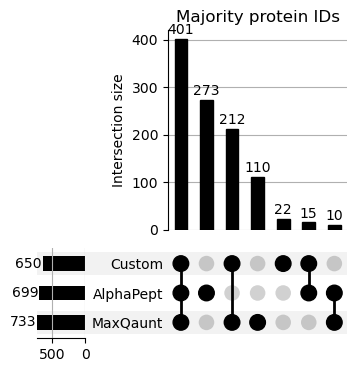

In [44]:
generate_upset_plot(intensities, 'ProteinGroup', 'Majority protein IDs', is_sorted=True, max_value=420)

In [45]:
intensities_2 = {
    'Custom': custom_res,
    'MaxQaunt': original_data
}

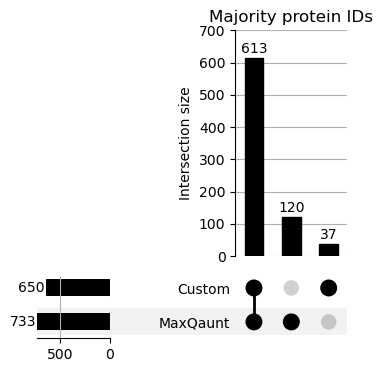

In [46]:
generate_upset_plot(intensities_2, 'ProteinGroup', 'Majority protein IDs', is_sorted=True, max_value=700)